# Домашнее задание Tiny YOLOv2

С помощью этого ноутбку вы познакомитесь с архитектурой **Tiny YOLOv2**.

Эта модель представляет собой нейронную сеть для обнаружения объектов 20 различных классов в реальном времени. Tiny YOLOv2 состоит из 9 сверточных слоев и 6 слоев с maxpooling и представляет собой уменьшенную версию более сложной сети YOLOv2.

Ноутбук состоит из следующих частей:

1.   Загрузка и визуализация данных
2.   Построение модели
3.   Первые предсказания необученной модели


Во второй части вам необходимо дописать код, заменив им комментарии *#YOUR CODE HERE*.





# Импорт библиотек

In [2]:
# Для загрцзки данных
import os
import tarfile
import urllib.request

# Для работы с изображениями
import torchvision
from PIL import Image
from IPython.display import display

# Для построения модели
import torch

# Загрузка данных 

Мы будем использовать набор данных PASCAL Visual Object Classes ([VOC](http://host.robots.ox.ac.uk/pascal/VOC/index.html)). 

Это набор размеченных изображений, заключенных в ограничивающие рамки. В наборе присутствует только 20 классов, что делает его идеальным набором для знакомства с задачей распознавания данных.

In [3]:
# Классы обьектов датасета VOC
CLASSES = (
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
)
CLASS2NUM = {class_:idx for idx, class_ in enumerate(CLASSES)}

# Загрузка датасета
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar", "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

Отлично! Данные сохранены в локальной директории. 

Теперь давайте создадим функцию для загрузки изображения как тензора PyTorch. При желании размер изображения можно изменить до заданного путем масштабирования.

In [4]:
def load_image(idx, size, device="cpu"):
    filename = f"VOCdevkit/VOC2012/JPEGImages/2008_{str(idx).zfill(6)}.jpg"
    img = Image.open(filename)
    transforms = [torchvision.transforms.ToTensor()]
    try:
        width, height = size
    except TypeError:
        width = height = size
    # Решэйпинг изображения
    scale = min(width / img.width, height / img.height)
    new_width, new_height = int(img.width * scale), int(img.height * scale)
    diff_width, diff_height = width - new_width, height - new_height
    resize = torchvision.transforms.Resize(size=(new_height, new_width))
    # Паддинг
    pad = torchvision.transforms.Pad(
        padding=(
            diff_width // 2,
            diff_height // 2,
            diff_width // 2 + diff_width % 2,
            diff_height // 2 + diff_height % 2,
        )
    )
    transforms = [resize, pad] + transforms
    transformation = torchvision.transforms.Compose(transforms)
    # Трансформация изображения
    x = transformation(img).to(device)
    return x


 Вспомогательные функции

In [5]:
def load_image_batch(idxs, size, device="cpu"):
    imgs = [load_image(idx, size=size, device="cpu") for idx in idxs]
    x = torch.stack(imgs, 0)
    return x.to(device)

In [6]:
def show_images(x):
    transform = torchvision.transforms.ToPILImage()
    if x.dim() == 3:
        display(transform(x))
    elif x.dim() == 4:
        for xx in x:
            display(transform(xx))
    else:
        raise ValueError

Отрисуем 4 изображения с произвольными индексами 

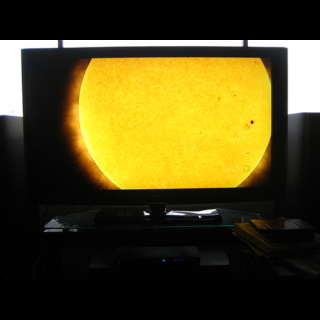

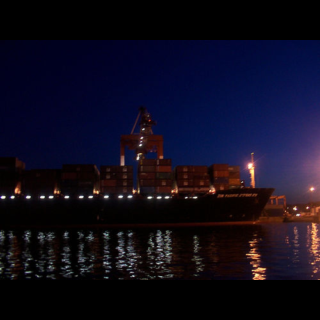

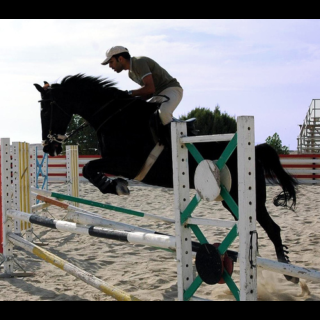

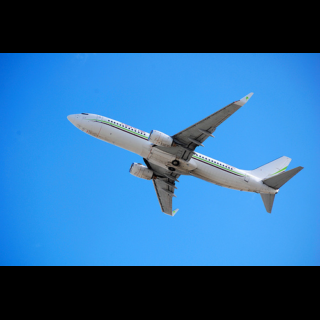

In [7]:
# Произведем решэйпинг изображения под размер 320x320 перед началом обучения нейронной сети, 
# чтобы можно было их подавать батчами (для ускорения обучения)

imgs = load_image_batch([2, 7, 8, 33], size=320)
show_images(imgs)

# Построение модели

Tiny YOLO состоит из нескольких сверточных слоев с добавлением активации Leaky ReLU. Эта активация аналогична обычной активации ReLU, но значения меньше нуля умножаются на 0.1 вместо 0.

![image.png](https://drive.google.com/uc?export=view&id=109QSNQWHrHSq7senX6FC5wODv8bld-77)

Опишем алгоритм работы Tiny YOLOv2:

1. На **вход** подается изображение с 3 каналами
2. Произаодим решэйпинг картинки
3. Делим картинку на клетки размером 10x10

![picture](https://drive.google.com/uc?export=view&id=1DUCu0f5_1LAEeNo11uOMfK00HSK8Y3PI)


Сосредоточимся на клетках, на которые мы разделили изобрадение. Такие клетки, которые называются grid cells, лежат в основе идеи YOLO. Каждая клетка является **«якорем»**, к которому прикрепляются рамки (bounding boxes). 

То есть вокруг клетки рисуются несколько прямоугольников для определения объекта (поскольку непонятно, какой формы прямоугольник будет наиболее подходящим, их рисуют сразу несколько и разных форм), и их позиции, ширина и высота вычисляются относительно центра этой клетки.

Для определяния размера и позиции рамок используются  «**якорные прямоугольники**» (anchor boxes). Они фиксируются. Задают нескольк различных anchor boxes, которые будут нарисованы вокруг или внутри одной клетки:

![picture](https://drive.google.com/uc?export=view&id=1jO5x97TmFZluIkSqvC36DXpev6iNsf0c)

4. Прогоняем изображение через YOLO. 

Теперь для каждой клетки, нам нужно ответить на два вопроса:

1) *Какой из нарисованных вокруг клетки якорных прямоугольников подходит больше всего,*

2) *Есть ли объект внутри anchor box и какой он.* 

На **выходе** получается тензор (1x5x10x10x25), где 10x10 - это количество ячеек сетки, на которые делится изображение. Каждая ячейка сетки соответствует 125 каналам, состоящим из 5 ограничивающих прямоугольников, предсказанных ячейкой сетки, и 25 элементов данных, которые описывают каждый ограничивающий прямоугольник (5x25 = 125).

## Задание

Допишите класс TinyYOLOv2, используя следующие слои:


```
1.   Convolution, 16 filters, size = 3, stride = 1, pad = 1, leaky ReLU
2.   MaxPool, size = 2, stride = 2
3.   Convolution, 32 filters, size = 3, stride = 1, pad = 1, leaky ReLU
4.   MaxPool, size = 2, stride = 2
5.   Convolution, 64 filters, size = 3, stride = 1, pad = 1, leaky ReLU    
6.   MaxPool, size = 2, stride = 2
7.   Convolution, 128 filters, size = 3, stride = 1, pad = 1, leaky ReLU
8.   MaxPool, size = 2, stride = 2
9.   Convolution, 256 filters, size = 3, stride = 1, pad = 1, leaky ReLU
10.  MaxPool, size = 2, stride = 2
11.  Convolution, 512 filters, size = 3, stride = 1, pad = 1, leaky ReLU
12.  MaxPool, size = 2, stride = 1
13.  Convolution, 1024 filters, size = 3, stride = 1, pad = 1, leaky ReLU
14.  Convolution, 1024 filters, size = 3, stride = 1, pad = 1, leaky ReLU
15.  Convolution, 125 filters, size = 3, stride = 1, pad = 1, leaky ReLU
16.  YOLO
```



In [29]:
class TinyYOLOv2(torch.nn.Module):
    def __init__(
        self,
        num_classes=20,
        # Предобпределим якорные прямоугольники в соответсвии со спецификацией Tiny YOLO VOC 
        # https://github.com/pjreddie/darknet/blob/master/cfg/yolov2-tiny-voc.cfg
        anchors=(
            (1.08, 1.19),
            (3.42, 4.41),
            (6.63, 11.38),
            (9.42, 5.11),
            (16.62, 10.52),
        ),
    ):
        super().__init__()

        # Parameters
        self.register_buffer("anchors", torch.tensor(anchors))
        self.num_classes = num_classes

        # Layers 
        self.relu = torch.nn.LeakyReLU(0.1, inplace=True)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.slowpool = torch.nn.MaxPool2d(2, 1)
        self.pad = torch.nn.ReflectionPad2d((0, 1, 0, 1))
        self.conv1 = torch.nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.norm1 = torch.nn.BatchNorm2d(16, momentum=0.1)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, 1, 1, bias=False)
        self.norm2 = torch.nn.BatchNorm2d(32, momentum=0.1)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        self.norm3 = torch.nn.BatchNorm2d(64, momentum=0.1)
        self.conv4 = torch.nn.Conv2d(64, 128, 3, 1, 1, bias=False)
        self.norm4 = torch.nn.BatchNorm2d(128, momentum=0.1)
        self.conv5 = torch.nn.Conv2d(128, 256, 3, 1, 1, bias=False)
        self.norm5 = torch.nn.BatchNorm2d(256, momentum=0.1)
        self.conv6 = torch.nn.Conv2d(256, 512, 3, 1, 1, bias=False)
        self.norm6 = torch.nn.BatchNorm2d(512, momentum=0.1)
        self.conv7 = torch.nn.Conv2d(512, 1024, 3, 1, 1, bias=False)
        self.norm7 = torch.nn.BatchNorm2d(1024, momentum=0.1)
        self.conv8 = torch.nn.Conv2d(1024, 1024, 3, 1, 1, bias=False)
        self.norm8 = torch.nn.BatchNorm2d(1024, momentum=0.1)
        self.conv9 = torch.nn.Conv2d(1024, len(anchors) * (5 + num_classes), 1, 1, 0)

    def forward(self, x, yolo=True):
        x = self.relu(self.pool(self.norm1(self.conv1(x))))
        x = self.relu(self.pool(self.norm2(self.conv2(x))))
        x = self.relu(self.pool(self.norm3(self.conv3(x))))
        x = self.relu(self.pool(self.norm4(self.conv4(x))))
        x = self.relu(self.pool(self.norm5(self.conv5(x))))
        x = self.relu(self.slowpool(self.pad(self.norm6(self.conv6(x)))))
        x = self.relu(self.norm7(self.conv7(x)))
        x = self.relu(self.norm8(self.conv8(x)))
        x = self.conv9(x)
        if yolo:
            x = self.yolo(x)
        return x
    
    def yolo(self, x):
        # Сохраним изначальную форму x
        nB, _, nH, nW = x.shape

        # Измените форму x-tensor: (batch size, # anchors, height, width, 5+num_classes)
        # x = x.view(nB, self.anchors.shape[0], -1, nH, nW).permute(0, 1, 3, 4, 2)
        x = x.reshape(nB, len(self.anchors), nH, nW, 5 + self.num_classes)

        # Получим нормированные вспомогательные тензоры
        anchors = self.anchors.to(dtype=x.dtype, device=x.device)
        range_y, range_x = torch.meshgrid(
            torch.arange(nH, dtype=x.dtype, device=x.device),
            torch.arange(nW, dtype=x.dtype, device=x.device),
        )
        anchor_x, anchor_y = anchors[:, 0], anchors[:, 1]
        
        # Найдем рамки 
        x = torch.cat([
            (x[:, :, :, :, 0:1].sigmoid() + range_x[None,None,:,:,None]) / nW,  # X center
            (x[:, :, :, :, 1:2].sigmoid() + range_y[None,None,:,:,None]) / nH,  # Y center
            (x[:, :, :, :, 2:3].exp() * anchor_x[None,:,None,None,None]) / nW,  # Width
            (x[:, :, :, :, 3:4].exp() * anchor_y[None,:,None,None,None]) / nH,  # Height
            x[:, :, :, :, 4:5].sigmoid(), # confidence
            x[:, :, :, :, 5:].softmax(-1), # classes
        ], -1)

        return x # (batch_size, # anchors, height, width, 5+num_classes)

Посмотрим, что произойдет, если мы используем Tiny YOLO на изображении самолета:

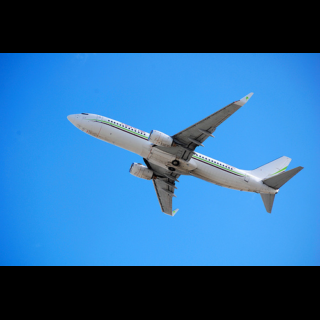

torch.Size([1, 5, 10, 10, 25])


In [30]:
model = TinyYOLOv2()
input = load_image_batch([33], 320) # батч, состоящий из единственного изображения самолета
show_images(input)
output = model(input)
print(output.shape)

Как видите, результатом прогона изображения по сети является тензор 1x5x10x10x25: 1 отдельный элемент батча, 5 bounding boxes, 10x10 ячеек и 25 признаков, предсказанных для каждого ограничивающего прямоугольника.

Первые 5 признаков из 25 описывают ограничивающие прямоугольники, а следующие 20 признаков описывают вероятность для ограничивающего прямоугольника содержания каждого из 20 возможных классов обьектов.

Мы можем попытаться визуализировать предсказанные ограничивающие рамки:

In [31]:
from PIL import ImageDraw

def show_images_with_boxes(input_tensor, output_tensor):
    to_img = torchvision.transforms.ToPILImage()
    for img, predictions in zip(input_tensor, output_tensor):
        img = to_img(img)
        if 0 in predictions.shape: # empty tensor
            display(img)
            continue
        confidences = predictions[..., 4].flatten()
        boxes = (
            predictions[..., :4].contiguous().view(-1, 4)
        )  # only take first four features: x0, y0, w, h
        classes = predictions[..., 5:].contiguous().view(boxes.shape[0], -1)
        boxes[:, ::2] *= img.width
        boxes[:, 1::2] *= img.height
        boxes = (torch.stack([
                    boxes[:, 0] - boxes[:, 2] / 2,
                    boxes[:, 1] - boxes[:, 3] / 2,
                    boxes[:, 0] + boxes[:, 2] / 2,
                    boxes[:, 1] + boxes[:, 3] / 2,
        ], -1, ).cpu().to(torch.int32).numpy())
        for box, confidence, class_ in zip(boxes, confidences, classes):
            if confidence < 0.01:
                continue # don't show boxes with very low confidence
            # make sure the box fits within the picture:
            box = [
                max(0, int(box[0])),
                max(0, int(box[1])),
                min(img.width - 1, int(box[2])),
                min(img.height - 1, int(box[3])),
            ]
            try:  # either the class is given as the sixth feature
                idx = int(class_.item())
            except ValueError:  # or the 20 softmax probabilities are given as features 6-25
                idx = int(torch.max(class_, 0)[1].item())
            try:
                class_ = CLASSES[idx]  # the first index of torch.max is the argmax.
            except IndexError: # if the class index does not exist, don't draw anything:
                continue

            
            color = (  # green color when confident, red color when not confident.
                int((1 - (confidence.item())**0.8 ) * 255),
                int((confidence.item())**0.8 * 255),
                0,
            )
            draw = ImageDraw.Draw(img)
            draw.rectangle(box, outline=color)
            draw.text(box[:2], class_, fill=color)
            
        display(img)

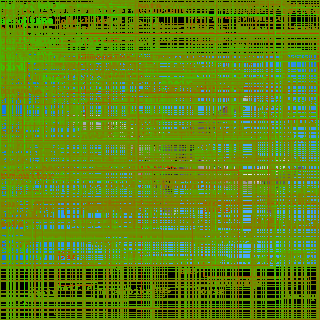

In [32]:
show_images_with_boxes(input, output)